In [1]:
import os
import shutil
import tempfile
import time
import glob

from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np
import csv
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset
from monai.utils import first, set_determinism
from monai.data.utils import pad_list_data_collate
from torch.amp import GradScaler, autocast
from tqdm import tqdm
import random

import pandas as pd

import nibabel as nib

from monai.inferers import DiffusionInferer
from monai.networks.nets import DiffusionModelUNet
from monai.networks.schedulers import DDPMScheduler

from monai.metrics import compute_iou

#print_config()

/bettik/PROJECTS/pr-gin5_aini/fehrdelt/environments/ddpm_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE_TYPE = "cuda:0"

In [3]:
#ROOT_DIR = "/home/fehrdelt/bettik/"
ROOT_DIR = "/bettik/PROJECTS/pr-gin5_aini/fehrdelt/"

In [4]:
set_determinism(0)

## Setup Dallas Healthy Lifespan ADC Dataset and training and validation dataloaders

2D 128x128 slices of 3D ADC volumes

In [5]:
IMAGE_SIZE = 128

In [6]:
train_csv = os.path.join(ROOT_DIR, "Code/data_splits_lists/ADC_Dallas_and_HCP-YA/train.csv")
train_images_path = []

with open(train_csv, mode='r') as file:
    reader = csv.reader(file)
    for line in tqdm(reader):
        #print(line)
        train_images_path.append(ROOT_DIR+line[0])

val_csv = os.path.join(ROOT_DIR, "Code/data_splits_lists/ADC_Dallas_and_HCP-YA/val.csv")
val_images_path = []

with open(val_csv, mode='r') as file:
    reader = csv.reader(file)
    for line in tqdm(reader):

        val_images_path.append(ROOT_DIR+line[0])

test_reconstruction_csv = os.path.join(ROOT_DIR, "Code/data_splits_lists/ADC_Dallas_and_HCP-YA/test.csv")
test_reconstruction_images_path = []

with open(test_reconstruction_csv, mode='r') as file:
    reader = csv.reader(file)
    for line in tqdm(reader):

        test_reconstruction_images_path.append(ROOT_DIR+line[0])


1572it [00:00, 52745.46it/s]
197it [00:00, 11740.07it/s]
197it [00:00, 10296.94it/s]


In [7]:
test_unhealthy_csv = os.path.join(ROOT_DIR, "Code/data_splits_lists/ADC_aini-stroke_unhealthy_test/ADC_aini-stroke_unhealthy_test.csv")
test_unhealthy_images_path = []

with open(test_unhealthy_csv, mode='r') as file:
    reader = csv.reader(file)
    for line in tqdm(reader):

        test_unhealthy_images_path.append(ROOT_DIR+line[0])

445it [00:00, 10814.20it/s]


In [11]:
#train_datalist = sorted(train_images_path)
train_datalist = train_images_path

#val_datalist = sorted(val_images_path)
val_datalist = val_images_path

#val_datalist = sorted(val_images_path)
test_reconstruction_datalist = test_reconstruction_images_path

test_unhealthy_datalist = test_unhealthy_images_path

batch_size = 8
num_workers = 4


In [12]:

train_transforms = transforms.Compose(
    [
        transforms.LoadImage(),
        transforms.EnsureChannelFirst(),
        transforms.RandAffine(prob=0.2, rotate_range=(0.15, 0.15, 0.15)),#+- 0.15 radians for each axis
        transforms.ScaleIntensityRange(a_min=0.0, a_max=4000.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandScaleCrop(roi_scale=0.9, max_roi_scale=1.1, random_size=True),
        transforms.ResizeWithPadOrCrop(spatial_size=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE)),
    ]
)
train_ds = CacheDataset(data=train_datalist[:batch_size], transform=train_transforms) #TODO datalist[:32]
train_loader = DataLoader(
    #collate_fn=pad_list_data_collate: any tensors are centrally padded to match the shape of the biggest tensor in each dimension
    train_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True, collate_fn=pad_list_data_collate
)

Loading dataset:   0%|                                                                                                                              | 0/8 [00:00<?, ?it/s]

Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  9.35it/s]


In [ ]:

val_transforms = transforms.Compose(
    [
        transforms.LoadImage(),
        transforms.EnsureChannelFirst(),
        transforms.ScaleIntensityRange(a_min=0.0, a_max=4000.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.ResizeWithPadOrCrop(spatial_size=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE)),
    ]
)
val_ds = CacheDataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True
)

In [ ]:


test_reconstruction_transforms = transforms.Compose(
    [
        transforms.LoadImage(),
        transforms.EnsureChannelFirst(),
        transforms.ScaleIntensityRange(a_min=0.0, a_max=4000.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.ResizeWithPadOrCrop(spatial_size=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE)),
    ]
)
test_reconstruction_ds = CacheDataset(data=test_reconstruction_datalist, transform=test_reconstruction_transforms)
test_reconstruction_loader = DataLoader(
    test_reconstruction_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True
)

### Visualisation of the training images

batch shape: torch.Size([8, 1, 128, 128, 128])
/bettik/PROJECTS/pr-gin5_aini/fehrdelt/datasets/ADC_Human_Connectome_Project_Young_Adult_HCP-YA_resized128/255639.nii.gz
/bettik/PROJECTS/pr-gin5_aini/fehrdelt/datasets/Dallas_ADC_rotated_resampled_registered/sub-1665_ses-wave1_ADC.nii.gz
/bettik/PROJECTS/pr-gin5_aini/fehrdelt/datasets/Dallas_ADC_rotated_resampled_registered/sub-611_ses-wave3_ADC.nii.gz
/bettik/PROJECTS/pr-gin5_aini/fehrdelt/datasets/Dallas_ADC_rotated_resampled_registered/sub-141_ses-wave2_ADC.nii.gz


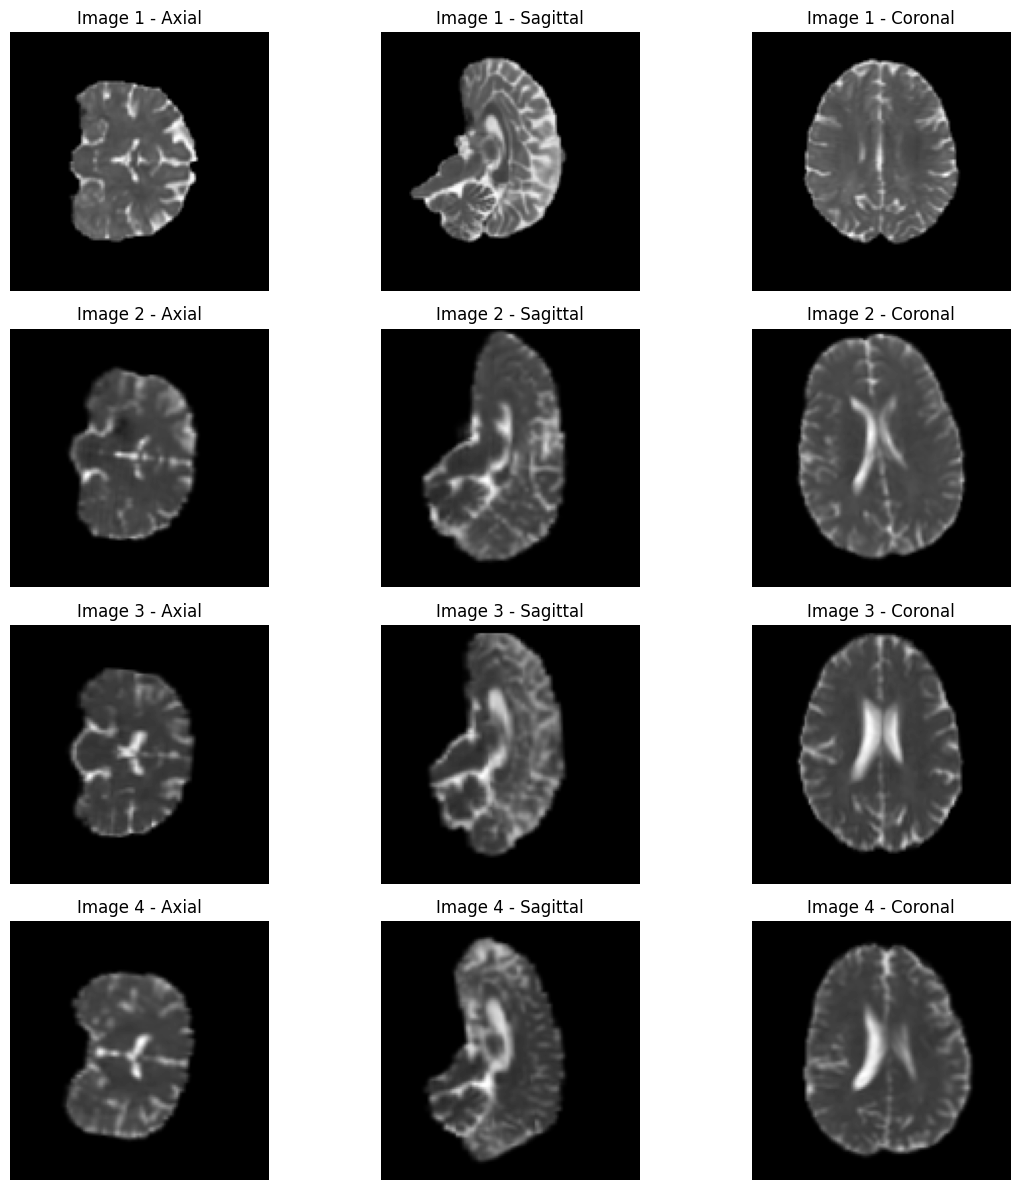

In [17]:

for i, batch in enumerate(train_loader):
    if i == 0:
        print(f"batch shape: {batch.shape}")
        fig, axes = plt.subplots(4, 3, figsize=(12, 12))
        for idx in range(4):
            
            image = batch[idx+4, 0].cpu().numpy()
            print(f"{train_datalist[idx+4]}")

            axial_slice = image[image.shape[0] // 2, :, :]
            sagittal_slice = image[:, image.shape[1] // 2, :]
            coronal_slice = image[:, :, image.shape[2] // 2]

            axes[idx, 0].imshow(axial_slice, cmap="gray")
            axes[idx, 0].set_title(f"Image {idx+1} - Axial")
            axes[idx, 0].axis("off")

            axes[idx, 1].imshow(sagittal_slice, cmap="gray")
            axes[idx, 1].set_title(f"Image {idx+1} - Sagittal")
            axes[idx, 1].axis("off")

            axes[idx, 2].imshow(coronal_slice, cmap="gray")
            axes[idx, 2].set_title(f"Image {idx+1} - Coronal")
            axes[idx, 2].axis("off")

        plt.tight_layout()
        plt.show()
        break


**!! Les Dallas sont de moins bonne qualité et pas la bonne épaisseur de slice !!**

**Les HCP-YA c'est bon**

In [ ]:
dallas_adc_unprocessed_list = [
    "/bettik/PROJECTS/pr-gin5_aini/fehrdelt/datasets/Dallas_Computed_ADC_extracted_brain/sub-1665_ses-wave1_ADC.nii.gz",
    "/bettik/PROJECTS/pr-gin5_aini/fehrdelt/datasets/Dallas_Computed_ADC_extracted_brain/sub-611_ses-wave3_ADC.nii.gz",
    "/bettik/PROJECTS/pr-gin5_aini/fehrdelt/datasets/Dallas_Computed_ADC_extracted_brain/sub-141_ses-wave2_ADC.nii.gz"]


train_unprocessed_transforms = transforms.Compose(
    [
        transforms.LoadImage(),
        transforms.EnsureChannelFirst(),
        transforms.Spacing(pixdim=(1.0, 1.0, 1.0), mode="bilinear"),  # <--------------  Resample to 1mm^3 isotropic
        transforms.RandAffine(prob=0.2, rotate_range=(0.15, 0.15, 0.15)),  # +- 0.15 radians for each axis
        transforms.ScaleIntensityRange(a_min=0.0, a_max=4000.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandScaleCrop(roi_scale=0.9, max_roi_scale=1.1, random_size=True),
        transforms.Resize(spatial_size=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE), mode="trilinear"),
        transforms.ResizeWithPadOrCrop(spatial_size=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE)),
    ]
)

train_unprocessed_ds = CacheDataset(data=dallas_adc_unprocessed_list, transform=train_unprocessed_transforms)
train_unprocessed_loader = DataLoader(
    #collate_fn=pad_list_data_collate: any tensors are centrally padded to match the shape of the biggest tensor in each dimension
    train_unprocessed_ds, batch_size=3, shuffle=False, num_workers=num_workers, persistent_workers=True, collate_fn=pad_list_data_collate
)

Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.90it/s]


batch shape: torch.Size([3, 1, 128, 128, 128])


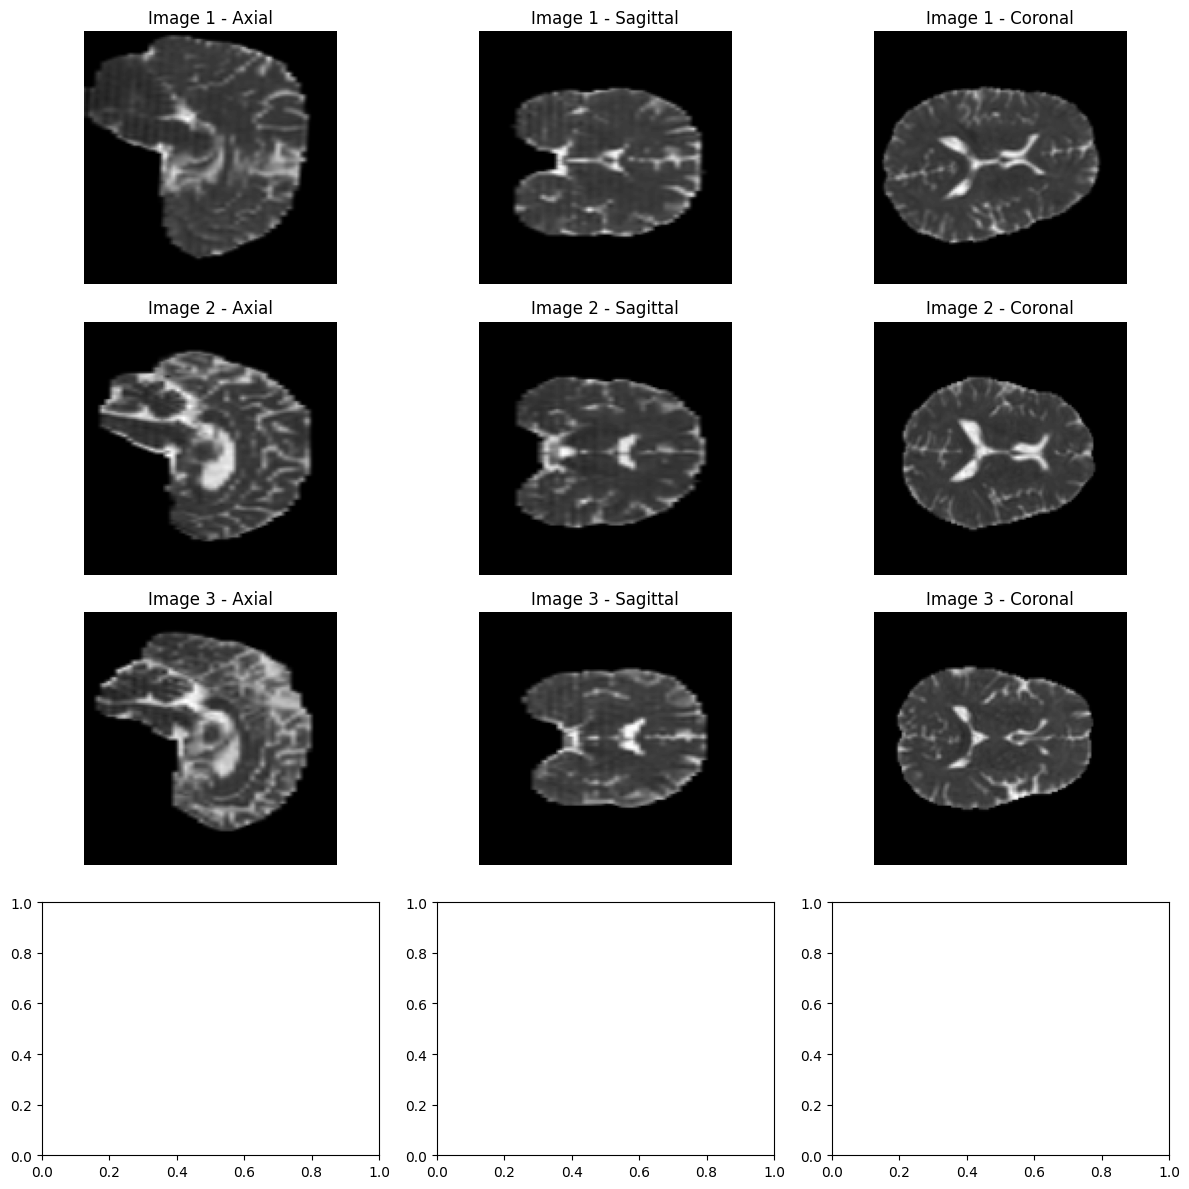

In [24]:
for i, batch in enumerate(train_unprocessed_loader):
    if i == 0:
        print(f"batch shape: {batch.shape}")
        fig, axes = plt.subplots(4, 3, figsize=(12, 12))
        for idx in range(3):
            
            image = batch[idx, 0].cpu().numpy()

            axial_slice = image[image.shape[0] // 2, :, :]
            sagittal_slice = image[:, image.shape[1] // 2, :]
            coronal_slice = image[:, :, image.shape[2] // 2]

            axes[idx, 0].imshow(axial_slice, cmap="gray")
            axes[idx, 0].set_title(f"Image {idx+1} - Axial")
            axes[idx, 0].axis("off")

            axes[idx, 1].imshow(sagittal_slice, cmap="gray")
            axes[idx, 1].set_title(f"Image {idx+1} - Sagittal")
            axes[idx, 1].axis("off")

            axes[idx, 2].imshow(coronal_slice, cmap="gray")
            axes[idx, 2].set_title(f"Image {idx+1} - Coronal")
            axes[idx, 2].axis("off")

        plt.tight_layout()
        plt.show()
        break


In [29]:
dallas_adc_unprocessed_folder = "/bettik/PROJECTS/pr-gin5_aini/fehrdelt/datasets/Dallas_Computed_ADC_extracted_brain/"
dallas_resampled_output_folder = "/bettik/PROJECTS/pr-gin5_aini/fehrdelt/datasets/Dallas_Computed_ADC_extracted_brain_resampled/"

for image_path in glob.glob(os.path.join(dallas_adc_unprocessed_folder, "*.nii.gz")):
    image = nib.load(image_path)
    image_data = image.get_fdata()

    # Resample to 1mm^3 isotropic
    new_spacing = (1.0, 1.0, 1.0)
    resample_transform = transforms.Spacing(pixdim=new_spacing, mode="bilinear")
    resampled_image_data = resample_transform(image_data)

    # Save the resampled image
    output_path = os.path.join(dallas_resampled_output_folder, os.path.basename(image_path))
    nib.save(nib.Nifti1Image(resampled_image_data.numpy(), affine=np.eye(4)), output_path)


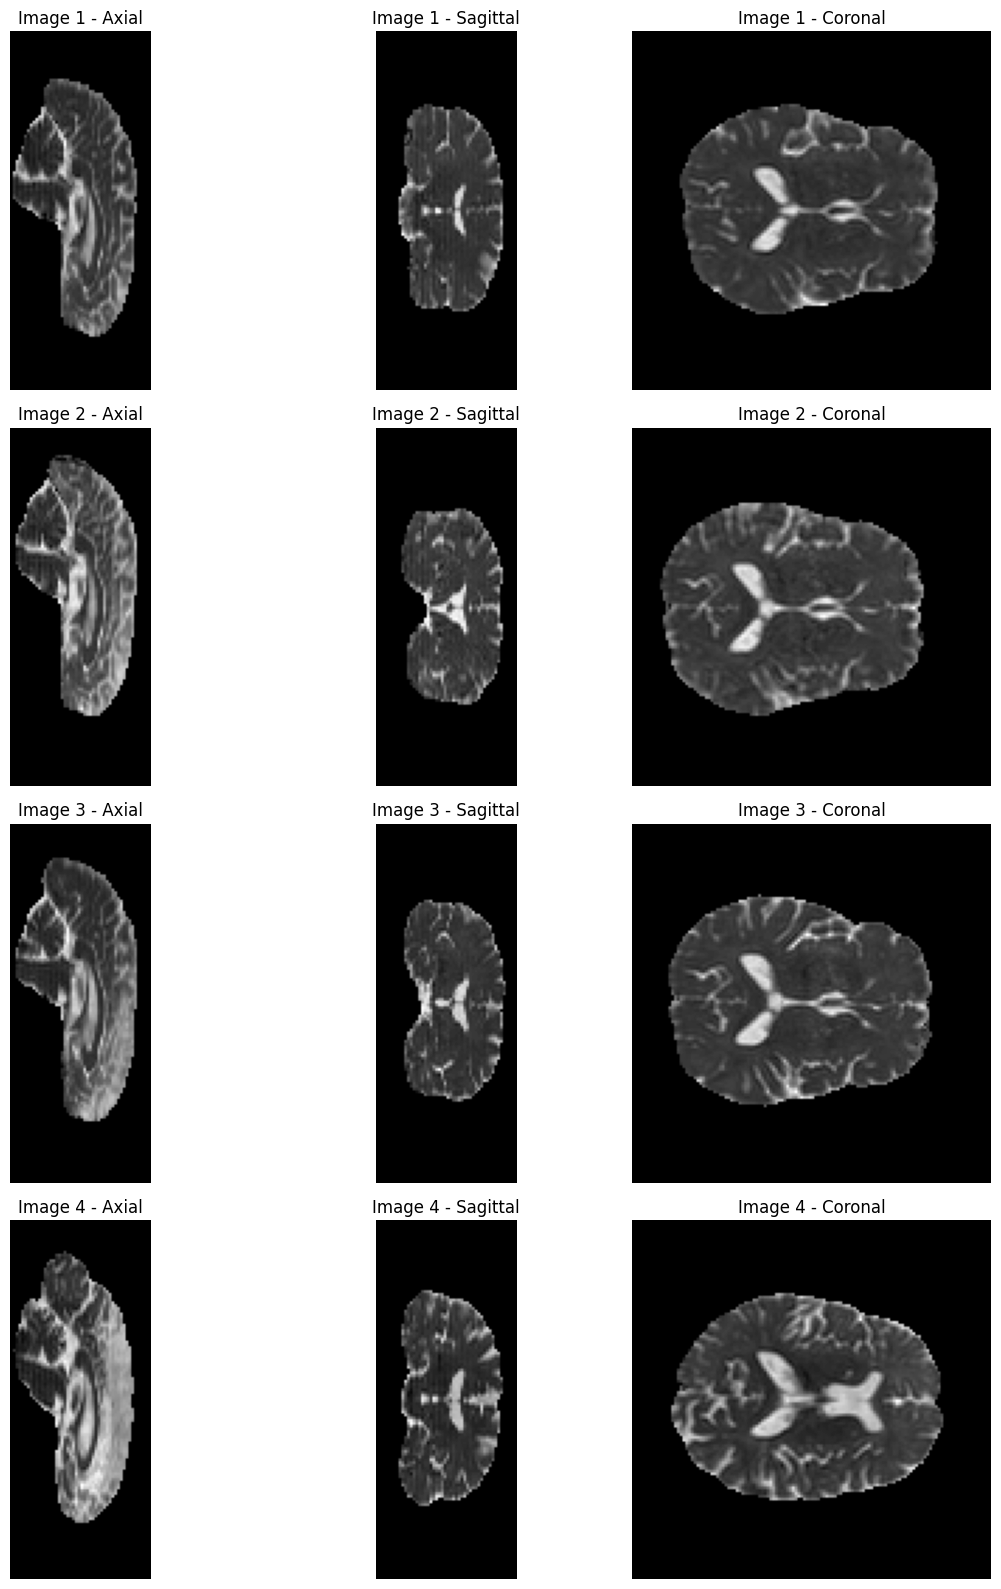

In [31]:
# Get the first 4 image paths from the folder
image_paths = sorted(glob.glob(os.path.join(dallas_resampled_output_folder, "*.nii.gz")))[:4]

# Plot the images
fig, axes = plt.subplots(4, 3, figsize=(12, 16))
for i, image_path in enumerate(image_paths):
    image = nib.load(image_path).get_fdata()

    # Extract slices
    axial_slice = image[image.shape[0] // 2, :, :]  # Middle axial slice
    sagittal_slice = image[:, image.shape[1] // 2, :]  # Middle sagittal slice
    coronal_slice = image[:, :, image.shape[2] // 2]  # Middle coronal slice

    # Plot slices
    axes[i, 0].imshow(axial_slice, cmap="gray")
    axes[i, 0].set_title(f"Image {i+1} - Axial")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(sagittal_slice, cmap="gray")
    axes[i, 1].set_title(f"Image {i+1} - Sagittal")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(coronal_slice, cmap="gray")
    axes[i, 2].set_title(f"Image {i+1} - Coronal")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

**Faut les register aussi après**

In [ ]:

for i, batch in enumerate(val_loader):
    #print(i)
    if i==2:
     
        print(f"batch shape: {batch.shape}")
        image_visualisation0 = torch.cat(
            [batch[0, 0], batch[1, 0], batch[2, 0], batch[3, 0]], dim=1
        )
        image_visualisation1 = torch.cat(
            [batch[4, 0], batch[5, 0], batch[6, 0], batch[7, 0]], dim=1
        )
        image_visualisation2 = torch.cat(
            [batch[8, 0], batch[9, 0], batch[10, 0], batch[11, 0]], dim=1
        )
        image_visualisation3 = torch.cat(
            [batch[12, 0], batch[13, 0], batch[14, 0], batch[15, 0]], dim=1
        )
        fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,figsize=(12, 12))
        
        ax0.imshow(image_visualisation0, cmap="gray")
        ax1.imshow(image_visualisation1, cmap="gray")
        ax2.imshow(image_visualisation2, cmap="gray")
        ax3.imshow(image_visualisation3, cmap="gray")
        plt.axis("off")
        plt.tight_layout()
        plt.show()


In [ ]:

for i, batch in enumerate(test_reconstruction_loader):
    #print(i)
    if i==0:
     
        print(f"batch shape: {batch.shape}")
        image_visualisation0 = torch.cat(
            [batch[0, 0], batch[1, 0], batch[2, 0], batch[3, 0]], dim=1
        )
        image_visualisation1 = torch.cat(
            [batch[4, 0], batch[5, 0], batch[6, 0], batch[7, 0]], dim=1
        )
        image_visualisation2 = torch.cat(
            [batch[8, 0], batch[9, 0], batch[10, 0], batch[11, 0]], dim=1
        )
        image_visualisation3 = torch.cat(
            [batch[12, 0], batch[13, 0], batch[14, 0], batch[15, 0]], dim=1
        )
        fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,figsize=(12, 12))
        
        ax0.imshow(image_visualisation0, cmap="gray")
        ax1.imshow(image_visualisation1, cmap="gray")
        ax2.imshow(image_visualisation2, cmap="gray")
        ax3.imshow(image_visualisation3, cmap="gray")
        plt.axis("off")
        plt.tight_layout()
        plt.show()


### Define network, scheduler, optimizer, and inferer
**!! Est ce qu'il vaut mieux que je prenne exactement le même modèle que dans les experiences en 2D ? (attention levels, scheduler etc)?**
We will use a DDPM in this example; for that, we need to define a `DiffusionModelUNet` network that will have as input the noisy images and the values for the timestep `t`, and it will predict the noise that is present in the image.

In this example, we have a network with three levels (with 256, 256, and 512 channels in each). In every level, we will have two residual blocks, and only the last one will have an attention block with a single attention head (with 512 channels).

In [ ]:
device = torch.device(DEVICE_TYPE)

model = DiffusionModelUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=[64, 64, 128],
    attention_levels=[False, False, True], # est ce que je garde ou je prend comme exp_2-1 ?
    num_head_channels=[0, 0, 128], # est ce que je garde ou je prend comme exp_2-1 ?
    num_res_blocks=2, # est ce que je garde ou je prend comme exp_2-1 ?
).to(device)

num_train_timesteps = 1000

scheduler = DDPMScheduler(
    num_train_timesteps=num_train_timesteps,
    schedule="scaled_linear_beta",
    beta_start=0.0005, # est ce que je garde ou je prend comme exp_2-1 ?
    beta_end=0.0195, # est ce que je garde ou je prend comme exp_2-1 ?
    clip_sample=False, # est ce que je garde ou je prend comme exp_2-1 ?
)


optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)

inferer = DiffusionInferer(scheduler)

Together with our U-net, we need to define the Noise Scheduler for the diffusion model. This scheduler is responsible for defining the amount of noise that should be added in each timestep `t` of the diffusion model's Markov chain. Besides that, it has the operations to perform the reverse process, which will remove the noise of the images (a.k.a. denoising process). In this case, we are using a `DDPMScheduler`. Here we are using 1000 timesteps and a `scaled_linear` profile for the beta values (proposed in [Rombach et al. "High-Resolution Image Synthesis with Latent Diffusion Models"](https://arxiv.org/abs/2112.10752)). This profile had better results than the `linear, proposed in the original DDPM's paper. In `beta_start` and `beta_end`, we define the limits for the beta values. These are important to determine how accentuated is the addition of noise in the image.

### Model training

In [ ]:
writer = SummaryWriter(ROOT_DIR+"Code/Tensorboard/Experiment_4-1_ADC_3d_ddpm")

max_epochs = 6000
val_interval = 3
epoch_loss_list = []
val_epoch_loss_list = []

best_val_epoch_loss = np.inf
best_val_epoch = 0

scaler = GradScaler(DEVICE_TYPE)
total_start = time.time()
for epoch in range(max_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch.to(device)
        optimizer.zero_grad(set_to_none=True)

        with autocast(device_type=DEVICE_TYPE, enabled=True):
            # Generate random noise
            noise = torch.randn_like(images).to(device)
            #noise = generate_simplex_noise(simplexObj, images.shape).to(device)

            # Create timesteps
            timesteps = torch.randint(0, num_train_timesteps, (images.shape[0],), device=images.device).long()

            # Get model prediction
            noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)

            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        epoch_len = len(train_ds)
        

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})

    epoch_loss_list.append(epoch_loss / (step + 1))
    writer.add_scalar("train_loss", epoch_loss / (step + 1), epoch)

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        for step, batch in enumerate(val_loader):
            images = batch.to(device)
            with torch.no_grad(), autocast(device_type=DEVICE_TYPE, enabled=True):
                noise = torch.randn_like(images).to(device)
                #noise = generate_simplex_noise(simplexObj, shape=images.shape).to(device)

                timesteps = torch.randint(0, num_train_timesteps, (images.shape[0],), device=images.device).long()
                noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
                val_loss = F.mse_loss(noise_pred.float(), noise.float())

            val_epoch_loss += val_loss.item()

            progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})

        val_epoch_loss_list.append(val_epoch_loss / (step + 1))
        writer.add_scalar("val_loss", val_epoch_loss / (step + 1), epoch)   # moi

        if val_epoch_loss < best_val_epoch_loss:
            best_val_epoch_loss = val_epoch_loss
            best_val_epoch = epoch + 1
            torch.save(
                model.state_dict(),
                os.path.join(ROOT_DIR+"Code/Best_models/3d_ddpm", "Experiment_4-1_ADC_3d_ddpm_best_metric_model_dallas_and_hcp_ya.pth"),
            )
            print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current val loss: {val_epoch_loss:.4f}"
                f"\nbest val loss: {best_val_epoch_loss:.4f}"
                f" at epoch: {best_val_epoch}"
            )
            writer.add_scalar("best_val_loss", best_val_epoch_loss, best_val_epoch)


        if (epoch + 1) % (val_interval*4) == 0:
            # Sampling image during training
            noise = torch.randn_like(images).to(device)
            #noise = generate_simplex_noise(simplexObj, shape=(1,1,IMAGE_SIZE, IMAGE_SIZE)).to(device)
            noise = noise.to(device)
            scheduler.set_timesteps(num_inference_steps=1000)
            with autocast(device_type=DEVICE_TYPE, enabled=True):
                image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)
            writer.add_image("sampled_image", image[0, 0].cpu().numpy(), global_step=epoch, dataformats="HW")
            #plt.figure(figsize=(2, 2))
            #plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
            #plt.tight_layout()
            #plt.axis("off")
            #plt.show()

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")